In [1]:
import pandas as pd

In [2]:
import os
os.chdir('./..')

In [2]:
import data

ModuleNotFoundError: No module named 'data'

In [3]:
import numpy as np

In [4]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [5]:
import xgboost as xgb

In [6]:
import matplotlib.pyplot as plt

In [7]:
from utils.check_folder import check_folder

ModuleNotFoundError: No module named 'utils'

In [8]:
import pickle

In [9]:
from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()

## Build the dataset

In [12]:
def existsIndex(df, idx):
    try:
        df.loc[idx]
        return True
    except KeyError:
        return False

In [13]:
def RepresentsInt(s):
    try: 
        int(s)
        return True
    except TypeError:
        return False
    except ValueError:
        return False

In [14]:
df = data.train_df('full').head(100000)

/home/giovanni/miniconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [18]:
def func(x):
    y = x[x['action_type'] == 'clickout item']
    if len(y) > 0:
        clk = y.tail(1)
        head_index = x.head(1).index
        
        # considering only the past!
        x = x.loc[head_index.values[0]:clk.index.values[0]-1]
        
        impr = clk['impressions'].values[0].split('|')
        prices = list(map(int, clk['prices'].values[0].split('|')))
        sorted_prices = prices.copy()
        sorted_prices.sort()
        
        references = x['reference'].values
        
        # features
        features = {'times_impression_appeared': [],
                    'time_elapsed_from_last_time_impression_appeared': [], 'steps_from_last_time_impression_appeared': [],
                    'kind_action_reference_appeared': [], 'impression_position': [], 'label': [], 'price': [],
                    'price_position': []}
        count = 0
        for i in impr:
            indices = np.where(references == str(i))[0]

            features['impression_position'].append(count+1)
            features['price'].append(prices[count])
            features['price_position'].append(sorted_prices.index(prices[count]))
            if len(indices) > 0:
                row_reference = x.head(indices[-1]+1).tail(1)
                features['steps_from_last_time_impression_appeared'].append(len(x)-indices[-1])
                features['time_elapsed_from_last_time_impression_appeared'].append(int(clk['timestamp'].values[0] - row_reference['timestamp'].values[0]))
                features['kind_action_reference_appeared'].append(row_reference['action_type'].values[0])
            else:
                features['steps_from_last_time_impression_appeared'].append(0)
                features['time_elapsed_from_last_time_impression_appeared'].append(np.inf)
                features['kind_action_reference_appeared'].append('no_action')
    
            if clk['reference'].values[0] == i:
                features['label'].append(1)
                features['times_impression_appeared'].append(len(indices))
            else:
                features['label'].append(0)
                features['times_impression_appeared'].append(len(indices))
            
            count += 1
            
        return pd.DataFrame(features)


In [19]:
dataset = df.groupby(['user_id', 'session_id']).progress_apply(func)
one_hot = pd.get_dummies(dataset['kind_action_reference_appeared'])
dataset = dataset.drop(['kind_action_reference_appeared'],axis = 1)
#dataset = dataset.join(one_hot)

In [20]:
dataset = dataset.join(one_hot)
# del df

In [21]:
dataset

times_impression_appeared  \
user_id      session_id                                    
0004IOZI7CKF 0146f7cb014ba 0                           0   
                           1                           0   
                           2                          -1   
                           3                           0   
                           4                           0   
                           5                           0   
                           6                           0   
                           7                           0   
                           8                           0   
                           9                           0   
                           10                          0   
                           11                          0   
                           12                          0   
                           13                          0   
                           14                          0   
                           15                          0   
                           16                          0   
                           17                          0   
                           18                          0   
                           19                          0   
                           20                          0   
                           21                          0   
                           22                          0   
                           23                          0   
                           24                          0   
004STL2FQU99 24ab1f448fa9c 0                           0   
                           1                           0   
                           2                           0   
                           3                           0   
                           4                           0   
...                                                  ...   
ZZRDO4E49IX8 95b67d0f9cc2e 18                         -1   
                           19                          0   
                           20                          0   
                           21                          0   
                           22                          0   
ZZWHEYWBUNJB 04690b2bf9697 0                          -1   
                           1                           0   
                           2                           0   
                           3                           0   
                           4                           0   
                           5                           0   
                           6                           0   
                           7                           0   
                           8                           0   
                           9                           0   
                           10                          0   
                           11                          0   
                           12                          0   
                           13                          0   
                           14                          0   
                           15                          0   
                           16                          0   
                           17                          0   
                           18                          0   
                           19                          0   
                           20                          0   
                           21                          0   
                           22                          0   
                           23                          0   
                           24                          0   

                               time_elapsed_from_last_time_impression_appeared  \
user_id      session_id                                                          
0004IOZI7CKF 0146f7cb014ba 0                                               inf   
    

In [22]:
X, y = dataset.iloc[:, [1,2,3,5,6,7,8,9,10,11]],dataset.iloc[:,4]

## Split the data

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## Train on it

In [18]:
xg_reg = xgb.XGBClassifier(max_depth=10, learning_rate=0.1, n_estimators=100, silent=True, objective='binary:logistic', nthread=-1)#, colsample_bytree = 0.3, learning_rate = 0.1,
                #max_depth = 5, alpha = 10, n_estimators = 10)

In [19]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

### Feature importance

([<matplotlib.axis.XTick at 0x7f5689441278>,
 <a list of 170 Text xticklabel objects>)

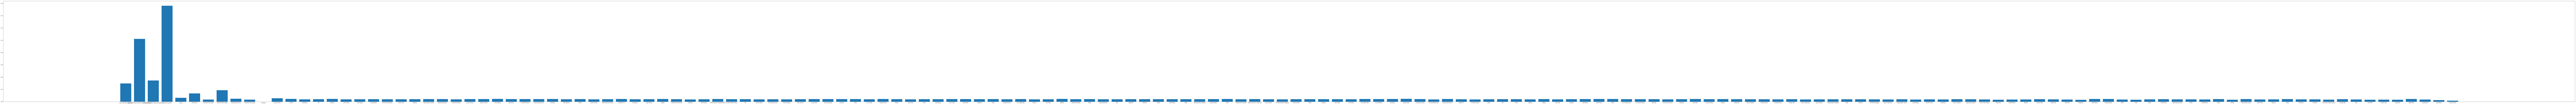

In [24]:
x = np.arange(len(X_train.columns.values))
fig, ax = plt.subplots(figsize=(500, 20))
plt.bar(x, height = xg_reg.feature_importances_) 
plt.xticks(x, X_train.columns.values)

## Training results

In [20]:
target_names = ['clk_diff_ref', 'clk_eq_ref']
print(classification_report(y_test, preds, target_names=target_names))

              precision    recall  f1-score   support

clk_diff_ref       0.97      1.00      0.99    192010
  clk_eq_ref       0.88      0.32      0.47      7990

   micro avg       0.97      0.97      0.97    200000
   macro avg       0.93      0.66      0.73    200000
weighted avg       0.97      0.97      0.96    200000



In [21]:
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.10%


In [34]:
preds

array([0, 0, 0, ..., 0, 0, 0])

## Dummy baseline (always say 0)

In [37]:
dummy = np.zeros(len(preds), dtype=np.int)

In [38]:
target_names = ['clk_diff_ref', 'clk_eq_ref']
print(classification_report(y_test, dummy, target_names=target_names))

              precision    recall  f1-score   support

clk_diff_ref       0.96      1.00      0.98    110364
  clk_eq_ref       0.00      0.00      0.00      5105

   micro avg       0.96      0.96      0.96    115469
   macro avg       0.48      0.50      0.49    115469
weighted avg       0.91      0.96      0.93    115469



/home/giovanni/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
accuracy = accuracy_score(y_test, dummy)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.58%
